# Manage events in holt-winters
This notebook presents a generic solution that allows to combine regressors with any statistical timeseries model.

In [1]:
from datetime import datetime

from mockseries.trend import Switch
from datetime import timedelta
from mockseries.trend import LinearTrend
from mockseries.noise import RedNoise

START_TIME = datetime(2020, 10,1)

## Timeseries simulation
Let's simulate a timeseries with a weekly seasonality, a yearly seasonality, a trend, and some noise.

### Weekly seasonality

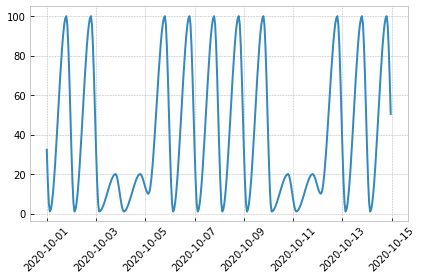

In [2]:
from mockseries.seasonality import WeeklySeasonality

constraints =  {
    timedelta(hours=3): 10,            ### EARLY MONDAY
    timedelta(days=1, hours=3): 1,    ### EARLY TUESDAY
    timedelta(days=2, hours=3): 1,    ### EARLY WEDNESDAY
    timedelta(days=3, hours=3): 1,    ### EARLY THURSDAY
    timedelta(days=4, hours=3): 1,    ### EARLY FRIDAY
    timedelta(days=5, hours=3): 1,    ### EARLY SATURDAY
    timedelta(days=6, hours=3): 1,    ### EARLY SUNDAY
    timedelta(hours=19): 100,         ### MONDAY EVENING
    timedelta(days=1, hours=19): 100, ### TUESDAY EVENING
    timedelta(days=2, hours=19): 100, ### WEDNESDAY EVENING
    timedelta(days=3, hours=19): 100, ### THURSDAY EVENING
    timedelta(days=4, hours=19): 100, ### FRIDAY EVENING
    timedelta(days=5, hours=19): 20,  ### SATURDAY EVENING
    timedelta(days=6, hours=19): 20,  ### SUNDAY EVENING
}
weekly_seasonality = WeeklySeasonality(constraints)
weekly_seasonality.preview_week(num_weeks=2, start_time=START_TIME)

### Yearly seasonality

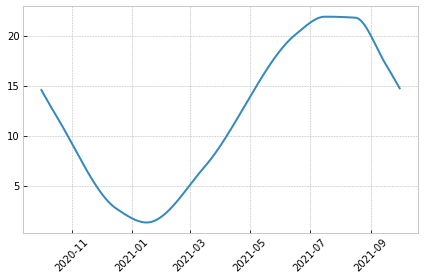

In [3]:
from mockseries.seasonality import YearlySeasonality
from mockseries.utils.timedeltas import JANUARY, MARCH, JUNE, JULY, AUGUST, SEPTEMBER, OCTOBER, DECEMBER

constraints = {
        JANUARY: 1.3,
        MARCH: 6.9,
        JUNE: 20.1,
        JULY: 21.9,
        AUGUST: 21.8,
        SEPTEMBER: 17.1,
        OCTOBER: 12,
        DECEMBER: 2.7,
    }
yearly_seasonality = YearlySeasonality(constraints)

yearly_seasonality.preview_year(start_time=START_TIME)

### Trend

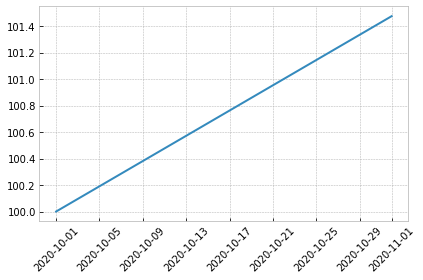

In [4]:
trend = LinearTrend(coefficient=1, time_unit=timedelta(days=21), flat_base=100)
trend.preview_month(start_time=START_TIME)

## Noise

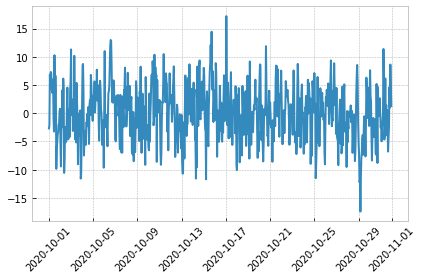

In [5]:
noise = RedNoise(mean=0, std=5, correlation=0.5)
noise.preview_month(start_time=START_TIME)

### Combine all signals

1 week


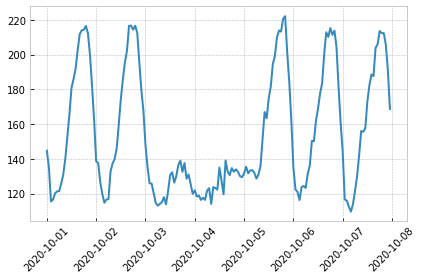

1 month


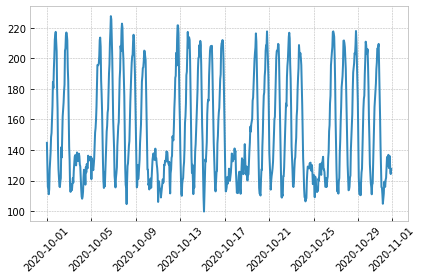

1 year


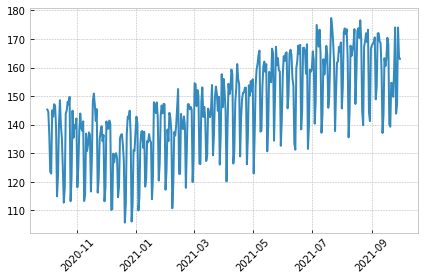

In [6]:
timeseries = (trend + yearly_seasonality + weekly_seasonality + noise)

print("1 week")
timeseries.preview_week(start_time=START_TIME)
print("1 month")
timeseries.preview_month(start_time=START_TIME)
print("1 year")
timeseries.preview_year(start_time=START_TIME)

### Add special events
Let's add christmas and sales as events.
Christmas is always at the same date.
Sales date and length can change.

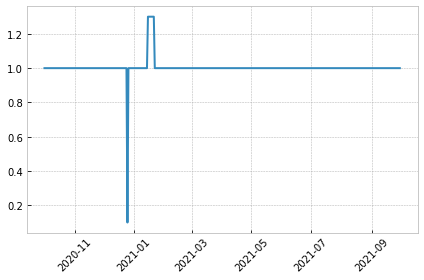

In [7]:
CHRISTMAS_2020_START = datetime(2020, 12, 25)
CHRISTMAS_2020_END = datetime(2020, 12, 26)
SALES_2021_START = datetime(2021, 1, 15)
SALES_2021_END = datetime(2021, 1, 22)

christmas_impact = Switch(
    start_time=CHRISTMAS_2020_START,
    base_value=1,
    switch_value=0.1,
    stop_time=CHRISTMAS_2020_END,
    )


sales_impact = Switch(
    start_time=SALES_2021_START,
    base_value=1,
    switch_value=1.3,
    stop_time=SALES_2021_END,
    )

event_impact = christmas_impact * sales_impact
event_impact.preview_year(start_time=START_TIME)

Timeseries with special events:

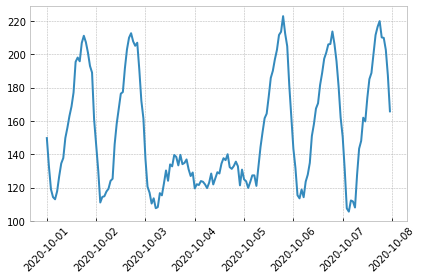

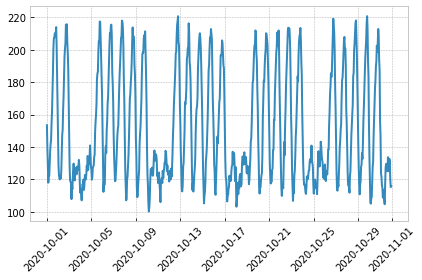

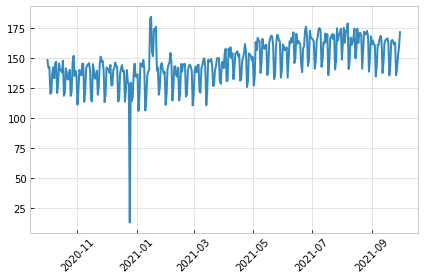

In [8]:
timeseries *= event_impact

timeseries.preview_week(start_time=START_TIME)
timeseries.preview_month(start_time=START_TIME)
timeseries.preview_year(start_time=START_TIME)

Generate the final training timeseries:
1 year of data starting from 2020-10-01.

In [9]:
from mockseries.utils import datetime_range
# timeseries times
END_TIME = START_TIME + timedelta(days=365)
time_points = datetime_range(
    granularity=timedelta(days=1),
    start_time=START_TIME,
    end_time=END_TIME,
)
# timeseries values
ts_train = timeseries.generate(time_points)

## How to fit the special events?
It is not easy to learn special events with Holt-Winters.
More generally, adding regressors to an ETS model can break some assumptions.
One solution is to introduce newer ML models that encode statistical knowledge similar to ETS.
These models can be challenging in terms of training stability and interpretability.

Another solutions described below is to train a simple regression on the timeseries regressors,
such that the regression will only be able to learn the mean value of the timeseries and the special events impact.
Then we can train an ETS model on the residuals of such models. The residuals should still contain a trend and a seasonality
because those will not have been learnt by the regression.
Special events should have been removed from the residuals because the regression will have learnt them.

In [10]:
import numpy as np
# generating the timeseries regressors
# - first regressor is an intercept (it's not automatically generated by statsmodels)
# - second regressor is an indicator function of Christmas
# - third regressor is an indicator function of a sales day
x_train = [[1 for _ in time_points],[int(tp == CHRISTMAS_2020_START) for tp in time_points], [int(SALES_2021_START<= tp < SALES_2021_END) for tp in time_points]]
x_train = np.transpose(x_train)

### Training the regression
Let's train a simple regression model:

In [11]:
import statsmodels.api as sm
import statsmodels.tools.tools
mod = sm.OLS(ts_train, x_train)
res = mod.fit()

In [12]:
res.params

array([146.49725349792345, -132.84156327029208, 24.447669490673707],
      dtype=object)

Model has learned that the mean is 146, christmas impacts is to remove 132, and sales impact is to add 24.
Let's look at the predictions of the model

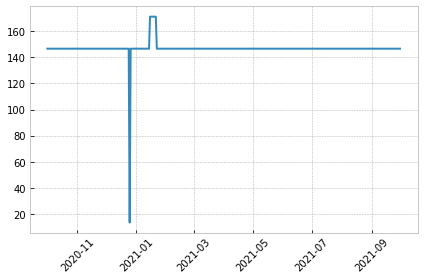

In [13]:
from mockseries.utils.plot import plot_timeseries
regressionPreds = res.get_prediction(x_train)
plot_timeseries(time_points, regressionPreds.predicted_mean, "Regression residuals")

Now let's look at the residuals as a timeseries:

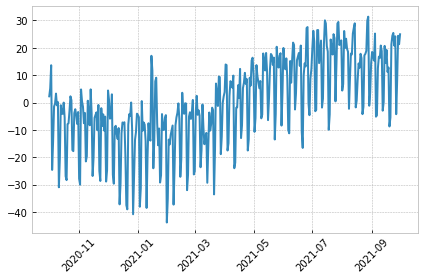

In [14]:
residuals = res.resid
plot_timeseries(time_points, residuals, "Regression residuals")

This still looks like a timeseries with a pattern that could be learnt:
but Christmas has been totally removed, and the sales impact has been partially removed.

residual = expected - predicted

So if the model is able to learn residuals correclty, we will be able to do predictions with:

expected = residual + predicted = ets(t) + regression(t)

Let's train an ETS Holt-Winters model on the residuals:

In [15]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

tsMod = ExponentialSmoothing(residuals, trend="add", damped_trend=False, seasonal="add", seasonal_periods=7)
tsRes = tsMod.fit()


Let's see if the model learned correctly: we should have residuals that look like white noise.

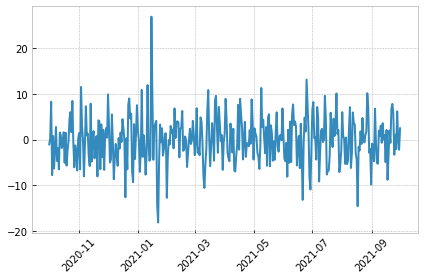

In [16]:
tsResiduals = tsRes.resid
plot_timeseries(time_points, tsResiduals, "Holt-Winters residuals")


This does look like noise. Notice the high residuals around the sales event: this is because the sales event
was not learned totally by the regression model.

Let's combine both models to see the results of the modelization:

/Users/cyril/PycharmProjects/holidayIntuitions/venv/lib/python3.8/site-packages/mockseries/utils/plot.py:31: UserWarning: List of <class 'numpy.float64'> passed instead of a np.ndarray. Converting to np array.
  warnings.warn(


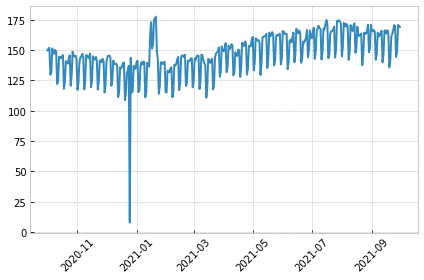

In [17]:
residualPreds = tsRes.fittedvalues
totalModel = [reg+resid for (reg, resid) in zip(regressionPreds.predicted_mean, residualPreds)]
plot_timeseries(time_points, totalModel, "Holt-Winters residuals")

This modelization seems close to the real timeseries. Let's check the model behaves correctly for forecasting

### Doing forecasts
Whether a day is a sales or Christmas is known in advance. We can use a list of event to generate the regressors that will be used for the regression.
We will perform forecasting for 1 year.

In [18]:
# upcoming events
CHRISTMAS_2021_START = datetime(2021, 12, 25)
CHRISTMAS_2021_END = datetime(2021, 12, 26)
# sales in 2022 is 2 weeks!
SALES_2022_START = datetime(2022, 1, 16)
SALES_2022_END = datetime(2022, 1, 30)

FORECAST_END_TIME = END_TIME + timedelta(days=365)

END_TIME = START_TIME + timedelta(days=365)
# timeseries time points
forecast_time_points = datetime_range(
    granularity=timedelta(days=1),
    start_time=END_TIME,
    end_time=FORECAST_END_TIME,
)
# timeseries regressors - first is an intercept (a bias) - not automatically built with stats models by default
x_forecast = [[1 for _ in forecast_time_points],[int(tp == CHRISTMAS_2021_START) for tp in forecast_time_points], [int(SALES_2022_START<= tp < SALES_2022_END) for tp in forecast_time_points]]
x_forecast = np.transpose(x_forecast)

regressionForecastPreds = res.get_prediction(x_forecast)
tsForecastResiduals = tsRes.forecast(365)

Let's look at the regression forecast:

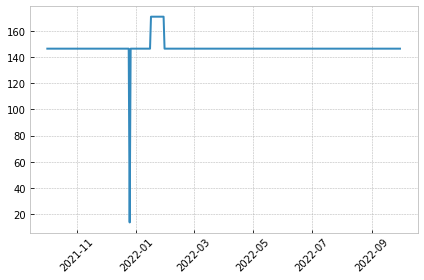

In [19]:
plot_timeseries(forecast_time_points, regressionForecastPreds.predicted_mean, "Regression Forecast")

Notice the sales impact is longer because the sales length is 2 weeks for the forecast.
--> the model can learn events that don't happen at the same time every year.
Let's look at the residual forecast:

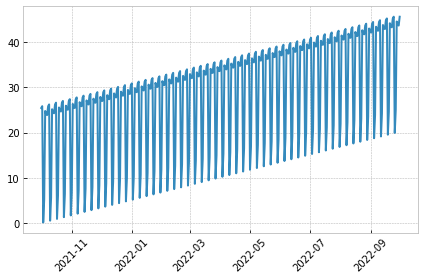

In [20]:
plot_timeseries(forecast_time_points, tsForecastResiduals, "Holt-Winters Forecast residuals")

Let's combine both to get the final forecast:

finalForecast = regressionForecast + residualForecast

/Users/cyril/PycharmProjects/holidayIntuitions/venv/lib/python3.8/site-packages/mockseries/utils/plot.py:31: UserWarning: List of <class 'numpy.float64'> passed instead of a np.ndarray. Converting to np array.
  warnings.warn(


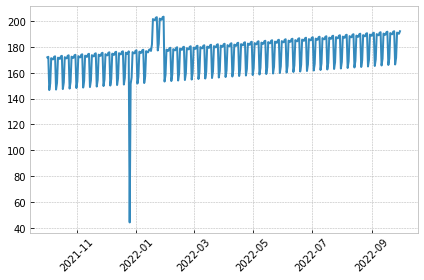

In [21]:
finalForecast = [reg+resid for (reg, resid) in zip(regressionForecastPreds.predicted_mean, tsForecastResiduals)]
plot_timeseries(forecast_time_points, finalForecast, "Final Forecast")


This looks like a relevant forecast.
- special events are managed
- seasonality, trend and level are good

Notice:
- yearly seasonality is not learned because holt-winters period is 7 day, and no month feature was passed to the regression.
Passing a month feature to the regression seems like a good idea, the regression would learn the mean for every month, but this could be impacted by the varying number of week-end in a month depending on the year.
So it would require a few years of data to work as expected. But old years can be irrelevant for training. So it depends on the data. A correct user facing implementation should give an easy way to choose the regressors to use. An even better implem should have a procedure to chose the regressors. A function of number of points, granularity, trend.

- Error bounds computation is not discussed here. They can be computed easily if the regression model is linear. Not sure yet for the general case.